# Predicting Student Admissions

In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/

_Note: Thanks Adam Uccello, for helping us debug!_

## 1. Load and visualize the data

To load the data, we will use a very useful data package called Pandas. You can read on Pandas documentation here:

In [17]:
import pandas as pd
data = pd.read_csv('student_data.csv')
data.head(13)

,admit,gre,gpa,rank
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0
5,1,760.0,3.00,2.0
6,1,560.0,2.98,1.0
7,0,400.0,3.08,2.0
8,1,540.0,3.39,3.0
9,0,700.0,3.92,2.0


Let's plot the data and see how it looks.

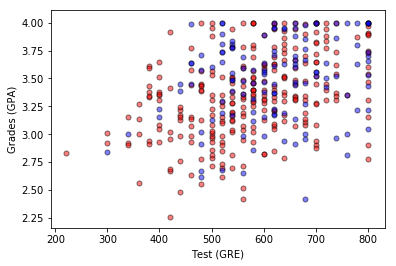

In [18]:
# Import our libraries
import matplotlib.pyplot as plt
import numpy as np

# I guess we'll go ahead and define a function that plots for us, why not.
def plot_points(data):
    
    # Put all our X's in one array
    X = np.array(data[["gre","gpa"]])
    
    # Put our y in an array
    y = np.array(data["admit"])
    
    # So we're going to define 2 things there, admitted and rejected and label them in 2 sepeerate classification arrays.
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    
    # So we design a scatter plot for our rejected points. The "s" is just an artifact of using list comprehension.
    # Pretty sure it's just there to confuse you for no reason.
    # So for each s and for each gra and gpa of s, rejected is color coded red.
    # Same for admitted except they're blue. Great.
    # also s is size and alpha is opacity.
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k', alpha = .5)
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'blue', edgecolor = 'k', alpha = .5)
    
    # Label our axis.
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    
# Create and show our graph.
plot_points(data)
plt.show()

The data, based on only GRE and GPA scores, doesn't seem very separable. Maybe if we make a plot for each of the ranks, the boundaries will be more clear.

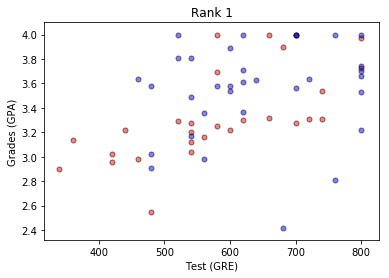

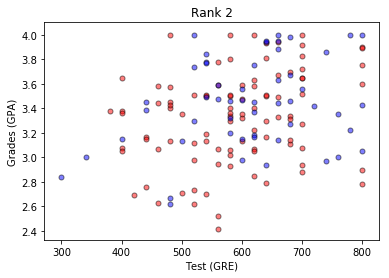

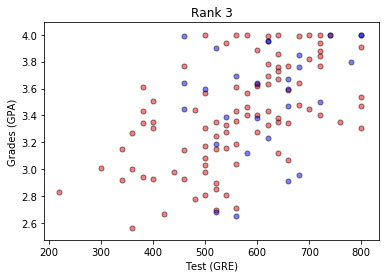

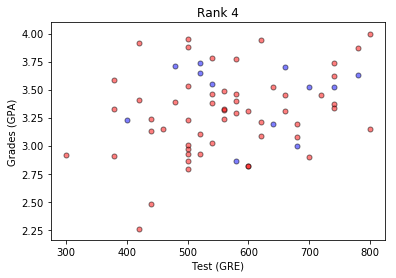

In [19]:
# So here we're just making seperate dataframes of each rank. Then re-plotting.
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]
plot_points(data_rank1)
plt.title("Rank 1")
plt.show()
plot_points(data_rank2)
plt.title("Rank 2")
plt.show()
plot_points(data_rank3)
plt.title("Rank 3")
plt.show()
plot_points(data_rank4)
plt.title("Rank 4")
plt.show()


These plots look a bit more linearly separable, although not completely. But it seems that using a multi-layer perceptron with the rank, gre, and gpa as inputs, may give us a decent solution.

# 2. Process the data
We'll do the following steps to clean up the data for training:
- One-hot encode the rank
- Normalize the gre and the gpa scores, so they'll be in the interval (0,1)
- Split the data into the input X, and the labels y.

In [20]:
# Import libraries
import keras
from keras.utils import np_utils

# remove NaNs
data = data.fillna(0)

# One-hot encoding the rank
processed_data = pd.get_dummies(data, columns=['rank'])

# Normalizing the gre and the gpa scores to be in the interval (0,1)
processed_data["gre"] = processed_data["gre"]/800
processed_data["gpa"] = processed_data["gpa"]/4

# Splitting the data input into X, and the labels y 
X = np.array(processed_data)[:,1:]
X = X.astype('float32')
y = keras.utils.to_categorical(data["admit"],2)

In [21]:
# Checking that the input and output look correct
print("Shape of X:", X.shape)
print("\nShape of y:", y.shape)
print("\nFirst 13 rows of X")
print(X[:13])
print("\nFirst 13 rows of y")
print(y[:13])

Shape of X: (400, 7)

Shape of y: (400, 2)

First 13 rows of X
[[ 0.47499999  0.90249997  0.          0.          0.          1.          0.        ]
 [ 0.82499999  0.91750002  0.          0.          0.          1.          0.        ]
 [ 1.          1.          0.          1.          0.          0.          0.        ]
 [ 0.80000001  0.79750001  0.          0.          0.          0.          1.        ]
 [ 0.64999998  0.73250002  0.          0.          0.          0.          1.        ]
 [ 0.94999999  0.75        0.          0.          1.          0.          0.        ]
 [ 0.69999999  0.745       0.          1.          0.          0.          0.        ]
 [ 0.5         0.76999998  0.          0.          1.          0.          0.        ]
 [ 0.67500001  0.84750003  0.          0.          0.          1.          0.        ]
 [ 0.875       0.98000002  0.          0.          1.          0.          0.        ]
 [ 1.          1.          0.          0.          0.          0.  

# 3. Split the data into training and testing sets

In [22]:
# break training set into training and validation sets
(X_train, X_test) = X[50:], X[:50]
(y_train, y_test) = y[50:], y[:50]

# print shape of training set
print('x_train shape:', X_train.shape)

# print number of training, validation, and test images
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (350, 7)
350 train samples
50 test samples


# 4. Define the model architecture

In [47]:
# Imports
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

# Building the model
# Note that filling out the empty rank as "0", gave us an extra column, for "Rank 0" students.
# Thus, our input dimension is 7 instead of 6.
model = Sequential()
model.add(Dense(128, activation='sigmoid', input_shape=(7,)))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(2, activation='softmax'))

# Compiling the model
model.compile(loss = 'mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               1024      
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 130       
Total params: 9,410
Trainable params: 9,410
Non-trainable params: 0
_________________________________________________________________


# 5. Train the model

In [48]:
# Training the model
model.fit(X_train, y_train, epochs=200, batch_size=25, verbose=0)

# 6. Score the model

In [49]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, y_train)
print("\n Training Accuracy:", score[1])
score = model.evaluate(X_test, y_test)
print("\n Testing Accuracy:", score[1])

 32/350 [=>............................] - ETA: 0s
 Training Accuracy: 0.705714285374
32/50 [==================>...........] - ETA: 0s
 Testing Accuracy: 0.62


# 7. Play with parameters!
You can see that we made several decisions in our training. For instance, the number of layers, the sizes of the layers, the number of epochs, etc.

It's your turn to play with parameters! Can you improve the accuracy? The following are other suggestions for these parameters. We'll learn the definitions later in the class:
- Activation function: relu and sigmoid
- Loss function: categorical_crossentropy, mean_squared_error
- Optimizer: rmsprop, adam, ada